## General Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from custom_functions import store_json

## Data Collection

In [17]:
# Make the Data RAM available
df_instances = pd.read_csv("./data/Train_call.txt", sep='\t')
df_solution = pd.read_csv("./data/Train_clinical.txt", sep='\t')

### Class Balance?

In [3]:
from collections import Counter
Counter(df_solution["Subgroup"])

Counter({'HER2+': 32, 'HR+': 36, 'Triple Neg': 32})

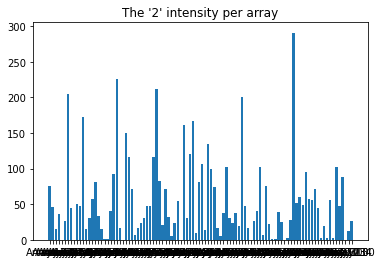

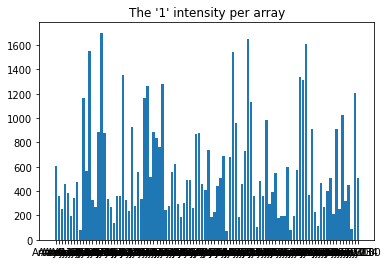

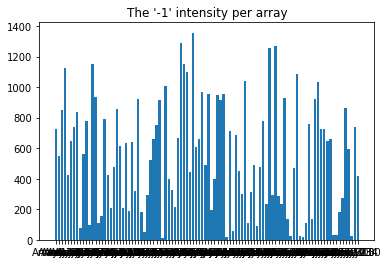

In [4]:
selection = dict()

for checkup in [2, 1, 0, -1]:
    new_key = str(checkup)
    col_name = "Array."

    selection[new_key] = df_instances[df_instances[[x for x in df_instances.columns if col_name in x]] == checkup].count()
    selection[new_key] = selection[new_key].to_dict()

    removables = [
        "Chromosome",
        "Start",
        "End",
        "Nclone",
    ]

    [selection[new_key].pop(name, None) for name in removables]

for intensity in selection:
    if intensity == "0":
        continue
    fig, ax = plt.subplots()
    ax.set_title(f"The '{intensity}' intensity per array")
    # print(f"The {intensity} intensity per array")
    plt.bar(*zip(*selection[intensity].items()))
    plt.show()

It seems to be in good shape

## Prep Data

In [18]:
# Transpose the df so we work with the instances on the index and features on columns (more conventional in ML)
df_instances = df_instances.T

In [19]:
df_solution.Subgroup.unique()

array(['HER2+', 'HR+', 'Triple Neg'], dtype=object)

In [7]:
def interchange(value):
    if value == "HR+":
        return 10
    elif value == "HER2+":
        return 11
    elif value == "Triple Neg":
        return 12
    else:
        raise ValueError(f"Value {value} is not supported!")

df_solution.Subgroup = df_solution.Subgroup.apply(lambda x: interchange(x))

### Potential Subquestion: Do regular numerical values as the target classification, instead of its categorical origin, create artefacts in feature selection?

In [22]:
# Assign the target value to the 'training data' so we have a superset

# Run this command on any given preconfigured dataset. If you set the target values as ints, the column is started as
# an int-based dtype. Otherwise, use None so we can assign strings
df_instances["Subgroup"] = None if type(df_solution.Subgroup.values[-1]) != int else 0

for arr_name in df_solution["Sample"]:
    df_instances.at[arr_name, "Subgroup"] =\
     df_solution[df_solution["Sample"] == arr_name]["Subgroup"].values[0]

In [24]:
# Check if the current progression happenend appropriately
df_instances

,0,1,2,3,4,5,6,7,8,9,...,2825,2826,2827,2828,2829,2830,2831,2832,2833,Subgroup
Chromosome,1,1,1,1,1,1,1,1,1,1,...,23,23,23,23,23,23,23,23,23,None
Start,2927,85022,370546,471671,792533,912799,1271190,1676445,1738295,2481927,...,152422390,152552851,152576854,152994680,153062077,153466463,153504394,153938998,153997146,None
End,43870,216735,372295,786483,907406,1266212,1590570,1703748,2477597,2562342,...,152548587,152570071,152935130,153054487,153452633,153491568,153933426,153989329,154492924,None
Nclone,3,4,4,5,13,96,45,4,104,14,...,20,6,64,5,57,4,55,5,43,None
Array.129,0,0,0,0,0,0,0,0,0,0,...,2,2,2,0,1,1,1,1,1,HER2+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Array.10,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,HER2+
Array.123,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,HR+
Array.100,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,HR+
Array.134,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,HR+


In [10]:
# Get the feature correlation so we can exclude (hopefully) a lot of features (since we are working with 2835 of them...)
corr_ = df_instances.corr()

In [11]:
# So we don't have to rerun it every time
# try:
#     corr_.to_csv("./data/correlations.csv")
# except:
#     print("Failed to store the correlations data permanently ;( ")
#     pass

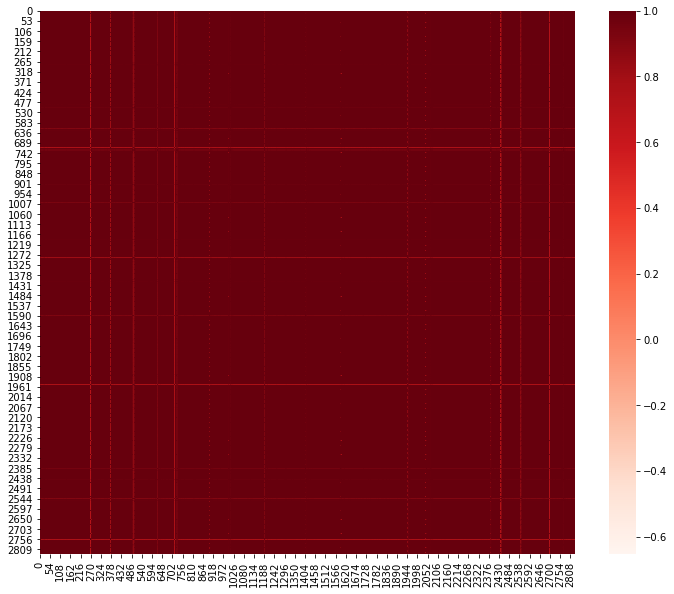

In [ ]:
# Lets see if we can plot it, because a plot can tell more than a thousands words (right?)
try:
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_, # annot=True, # Annotations will take an incredibly long time... better to leave them off
    cmap=plt.cm.Reds)
    plt.show()
except Exception as exc:
    print(f"While working without supervision...\nEncountered {exc}")

In [12]:
corr_

,0,1,2,3,4,5,6,7,8,9,...,2825,2826,2827,2828,2829,2830,2831,2832,2833,Subgroup
0,1.000000,0.952802,0.751004,0.888783,0.792765,0.846584,0.818860,0.754807,0.853392,0.759991,...,0.749708,0.749469,0.750215,0.749562,0.750283,0.749486,0.750364,0.749541,0.750505,-0.490009
1,0.952802,1.000000,0.916020,0.985979,0.940396,0.968216,0.954472,0.918322,0.971367,0.921436,...,0.915232,0.915086,0.915540,0.915143,0.915582,0.915097,0.915631,0.915130,0.915717,-0.598263
2,0.751004,0.916020,1.000000,0.970113,0.997839,0.987235,0.993974,0.999983,0.985094,0.999906,...,0.999998,0.999997,0.999999,0.999998,0.999999,0.999997,1.000000,0.999998,1.000000,-0.653786
3,0.888783,0.985979,0.970113,1.000000,0.983960,0.996377,0.990866,0.971499,0.997393,0.973350,...,0.969635,0.969547,0.969822,0.969581,0.969847,0.969553,0.969877,0.969573,0.969929,-0.633867
4,0.792765,0.940396,0.997839,0.983960,1.000000,0.995566,0.999028,0.998202,0.994267,0.998647,...,0.997709,0.997684,0.997760,0.997694,0.997767,0.997686,0.997775,0.997691,0.997789,-0.652272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,0.749486,0.915097,0.999997,0.969553,0.997686,0.986867,0.993719,0.999967,0.984696,0.999872,...,1.000000,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,-0.653783
2831,0.750364,0.915631,1.000000,0.969877,0.997775,0.987080,0.993867,0.999977,0.984927,0.999892,...,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,-0.653783
2832,0.749541,0.915130,0.999998,0.969573,0.997691,0.986880,0.993729,0.999968,0.984711,0.999873,...,1.000000,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,-0.653783
2833,0.750505,0.915717,1.000000,0.969929,0.997789,0.987114,0.993891,0.999979,0.984964,0.999895,...,0.999999,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,-0.653783


In [13]:
#Correlation with output variable
cor_target = abs(corr_.Subgroup)

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.653786] # 0.653786 is selected by looking at the data manually.

relevant_features

1194        0.653788
1198        0.653786
1200        0.653787
1878        0.653794
2045        0.653795
2046        0.653795
2047        0.653792
2052        0.653787
2055        0.653787
2060        0.653787
2061        0.653787
2442        0.653794
2549        0.653786
2765        0.653803
2771        0.653788
Subgroup    1.000000
Name: Subgroup, dtype: float64

Looks like we have our victims for the Neural Net:

In [16]:
selected_features = list(relevant_features.index)

store_json(selected_features, "./data/min_feat_selection.json")

Stored file at ./data/min_feat_selection.json


### Potential Subquestion: Does feature selection improve model performance / build-time?

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c915e4f9-60c2-40b5-a522-8a90cb3fd50a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>